In [2]:
import pandas as pd # pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
# from sklearn import impute 
from  scipy.stats import skew, kurtosis, shapiro,zscore
import datetime


plt.rc('axes', linewidth=2)
plt.rc('axes', labelsize= 16)
plt.rc('axes',titlesize = 18)
plt.rc('legend',fontsize=14)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
plt.rc('figure',figsize=(10,8))

def figure_layout(figsize=(10,8),titel="",xlabel="",ylabel="",fontsize_titel=18,fontsize_axis=16,fontsize_legend=14,fontsize_ticks=16):
    plt.figure(figsize=figsize)
    ax1 = plt.gca()
    plt.rc('legend',fontsize=fontsize_legend)
    plt.title(titel, fontsize=fontsize_titel, fontweight = 'bold')
    plt.grid(True)
    plt.xlabel(xlabel, fontsize=fontsize_axis)
    plt.ylabel(ylabel, fontsize=fontsize_axis)
    for tick in ax1.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize_ticks)
    #         tick.label1.set_fontweight('bold')
    for tick in ax1.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize_ticks)
    #     tick.label1.set_fontweight('bold')
    
    return ax1

fullYeardata = pd.read_csv("D:\Onedrive\Leuven\Final project\data\WrittenData\FullYeardata.csv",parse_dates=['date'], index_col='date') 
amount_measurements = fullYeardata.shape[0]
amount_meters = fullYeardata.shape[1]

# Imputing missing data

In [6]:
# Estimate the missing data based on previous and future observations
def estimated_mean_signal(test):
    # subsitude if necessary the first of january or the last day of december (general) then
    for col_ID in test.columns:
        missing_index = test.loc[pd.isna(test[col_ID]), :].index
        meanOfSerie = test[col_ID].mean()
        for date in missing_index:
            if date.dayofyear == 1 or date.dayofyear == 365:
            # if date.day == 1 or date.day == 31:
                estimation = meanOfSerie
                test.loc[date,col_ID] = estimation
    
    # subsitude the rest of the days
    for col_ID in test.columns:
        missing_index = test.loc[pd.isna(test[col_ID]), :].index
        for date in missing_index:
            n = 0
            next_measure_index = date + datetime.timedelta(days= 1)
            next_measure_value = test.loc[next_measure_index,col_ID]
            
            previous_measure_index = date + datetime.timedelta(days= -1)
            previous_measure_value = test.loc[previous_measure_index,col_ID]

            while np.isnan(next_measure_value) or np.isnan(previous_measure_value):
                n += 1
                            
                if np.isnan(next_measure_value) and np.isnan(previous_measure_value):

                    next_measure_index = date + datetime.timedelta(days= n + 1)
                    next_measure_value = test.loc[next_measure_index,col_ID]
                    previous_measure_index = date + datetime.timedelta(days= -1*(n + 1))
                    previous_measure_value = test.loc[next_measure_index,col_ID]
                
                elif np.isnan(next_measure_value):
                    next_measure_index = date + datetime.timedelta(days= n + 1)
                    next_measure_value = test.loc[next_measure_index,col_ID]

                elif np.isnan(previous_measure_value):
                    previous_measure_index = date + datetime.timedelta(days= -1*(n + 1))
                    previous_measure_value = test.loc[next_measure_index,col_ID]

                else:
                    raise Exception("Should have been excepted by one of the previous cases.")
                

            estimation = (next_measure_value + previous_measure_value)/2
            test.loc[date,col_ID] = estimation

In [7]:
fydc = fullYeardata.copy(deep=True)
fydc.isna().sum()

meter_2979    1344
meter_2980    1584
meter_2981    1344
meter_2982    1392
meter_2983    1392
              ... 
meter_3244    1392
meter_3245    2400
meter_3246    1344
meter_3247    1296
meter_3248    1392
Length: 270, dtype: int64

In [8]:
# estimation and subsitution of the missing values.
estimated_mean_signal(fydc)
fydc.isna().sum().sum()

0

# Removing outliers in the yearly consumption.

In [ ]:
fydc_sum = fydc.sum(axis=0)
print("This is the mean %s and this is the std %s." % (fydc_sum.mean(),fydc_sum.std()))
fydc_sum

In [ ]:
zscoreArray = zscore(fydc_sum,nan_policy="omit")
print("The original amount of meters: %s" % len(zscoreArray))
# remove the meters that have an outlier consumption. (> 3xstd)
# Assume that the yearly consumption is a normal distributed.
fydc_new = fydc.loc[:,list(abs(zscoreArray) < 3)]
print("The new amount of meters after outlier removal: %s" % fydc_new.shape[1])


In [ ]:
axes = figure_layout((10,8),"Zscore","meter ID","",18,16,14,16)
axes.scatter(np.arange(1,len(zscoreArray)+1), abs(zscoreArray))
# axes.legend(["Full dataset"])
plt.show()

# Removing time-series that have days with zero consumption

In [11]:
fyd_no_nan = fydc_new.copy(deep=True)
fyd_no_nan['meter_2985'].plot()

In [14]:
fydc_new_daily = fyd_no_nan.resample('D',axis=0).sum()
amountZeroDays = dict()

for col in fydc_new_daily.columns:
    count = 0
    for row in fydc_new_daily.index:
        value = fydc_new_daily.loc[row,col]
        if value == 0:
            count = count + 1
    amountZeroDays[col] = count

In [18]:
originalLength = fyd_no_nan.shape[1]
for key in amountZeroDays:
    if amountZeroDays[key] > 0:
        fyd_no_nan.drop(key,axis=1,inplace=True)
        print("Meter that is dropped: %s."%(key))
newLength = fyd_no_nan.shape[1]
print("Amount of meters original: %s.\nAfter removal: %s."%(originalLength,newLength))


Meter that is dropped: meter_2985.
Meter that is dropped: meter_3049.
Meter that is dropped: meter_3064.
Meter that is dropped: meter_3140.
Meter that is dropped: meter_3175.
Meter that is dropped: meter_3186.
Meter that is dropped: meter_3194.
Meter that is dropped: meter_3225.
Meter that is dropped: meter_3231.
Amount of meters original: 17520.
After removal: 17520.


In [19]:
fyd_no_nan.shape

(17520, 261)

# Normalizing time-series
Normalizing is done by looking at the minimum and maximum in the time-serie.

In [ ]:
fyc_update = fyd_no_nan.copy(deep=True)

In [ ]:
meter_min_max = dict()
for col in fyd.columns:
    ser = fyc_update[col]
    values = ser.values
    values = values.reshape((len(values), 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(values)
    print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
    addList = [scaler.data_min_,scaler.data_max_]
    meter_min_max[col] = addList
    normalized = scaler.transform(values)
    fyc_update[col] = normalized


# Removing time-series with a fundamental change in the data.

# Daily and weekly filters
The daily and weekly filter as described in 'Short term load forecasting with seasonal
decomposition using evolution for parameter tuning'. Missing days are ignored. The filters are applied on each individual time serie and then used as a template to fill in the missing values.


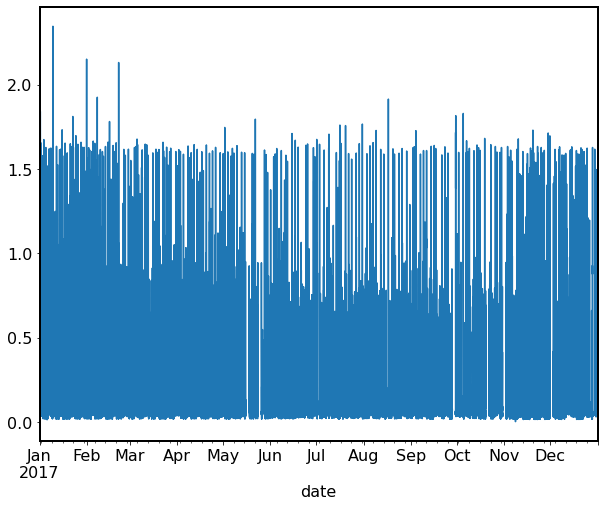

In [57]:
fullYeardata['meter_2982'].plot()

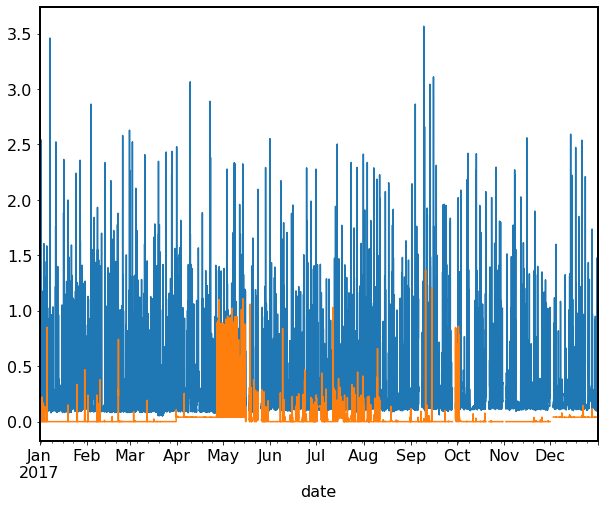

In [47]:
fullYeardata['meter_2979'].plot()
fullYeardata['meter_2985'].plot()